# Fluorescence Images without Fluorescent Markers

## Background and motivation

Fluorescence microscopy is one of the fundamental imaging tools we can use to see what is happening inside cells. The ability to attach fluorescent labels to specific proteins and structures of interest within cells has been nothing short of revolutionary in the field of cell biology, as with the ability to see what cell components are doing, also allows us to learn, piece by piece, how cells function. 

### The challenges of fluorescent imaging 

However, no technique is without its drawbacks and limitations. 
- Fluorescent markers can change the behaviors of the protein they are attached to, preventing normal interactions and regulatory processes. 
- The intense illumination needed to excite fluorescent markers causes photo-damage to the imaged cells. This damage ranges from potentially unnoticeable to a degree sufficient to cause cell death. This effect is worse when more illumination is used (as when there are relatively low levels of expressed protein) and worse when the fluorescent tag is primarily located on or adjacent to DNA (as with dyes that visualize the nucleus). 
- There are literal bandwidth limitations with fluorescent markers: you only have so many wavelengths you can use excite different tags and only so many wavelengths you can use to look at output. 

We are looking for ways we can side-step these limitations of fluorescent markers.

### Maybe labeled structures can be seen without fluorescent labels?

Fluorescent markers specifically highlight the structures of interest to make them easier to see, but these exist in the absence of markers. Large scale structures, such as the nucleus, are visible in traditional bright-field illumination; one can even manually segment or highlight them, given the time. 

![Bright-field with nuclear dye vs hand labeling](https://i.imgur.com/0IDg0yx.png)

However, it takes way too much time to do this for all the images we want to see, and the hand-labeled image isn't as clear as the dye-labeled one. Can we train a model to do this highlighting step for us, by feeding it the bright-field image as an input and the dye-labeled image as a target? 

A category of convolutional neural-net models, those based on the [U-net architecture](https://arxiv.org/abs/1505.04597), have shown themselves to be capable of biological image segmentation and style transfer. These model architectures reduce an image's dimensions, while detecting more and more features that can be used to classify whether a pixel would be fluorescent if it were labeled with a marker. After this categorization, the image is upsampled to its original resolution, with contextual information passed from the downsampling layers to provide context, increasing the realism of the upsampling (and placing the categorization in its original context).

![Placeholder unet architecture](https://raw.githubusercontent.com/zhixuhao/unet/master/img/u-net-architecture.png)

### Our contributions

We've trained such models on paired sets of our fluorescent images and the corresponding brightfield images. The details of our architecture and approach are described [in more detail in this pre-print](https://www.biorxiv.org/content/early/2018/03/27/289504), but let's take a look at how well structure prediction works, how close we are to being able to acquire fluorescence-like images without fluorescent markers.

## Predicting Fluorescence Images from Bright-field Images

### Getting Support Packages, the Model, and Input Images

This notebook runs well on [Google's Colaboratory Environment](https://drive.google.com/file/d/1aXtGzmqXxKTrraVZu0eg7JBf9Zt4iFFE/view?usp=sharing), which gives you access to nice GPUs from your laptop. We've also created a version to run this model across larger sets of images that allows you to [upload your own datasets](https://drive.google.com/file/d/1gIBqWhMCRxfX_NZgy_rAywEMh8QrpHQZ/view?usp=sharing). Before we begin in this environment however, we will need to install some packages and get local copies of the trained model and some input images to test it on.

In [0]:
## Package installation, restart runtime after packages install

# Image read and write
!pip install -q imageio

# Data and model downloading
!pip install -q quilt --user

# Model architecture and image pre-processing
# !pip install -q git+https://github.com/AllenCellModeling/pytorch_fnet.git
!pip install -q git+https://github.com/JacksonMaxfield/pytorch_fnet.git

# PyTorch to run the model 
!pip install -q http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl

After installing our packages we can now restart the runtime by viewing 'Runtime' options and then selecting 'Restart Runtime'.

In [0]:
# First the standard packages
import numpy as np
import json
import matplotlib.pyplot as plt
plt.set_cmap('gray')

# For image data
import scipy.ndimage
import tifffile

With our environment set up, we can download sample images of our cell lines.

In [0]:
# Download sample images from each of our cell lines
import quilt
quilt.install('aics/cell_line_samples')

# Load the cell line samples dataset
from quilt.data.aics import cell_line_samples

Let's take a look at the image we downloaded. Like all of the images in the `cell_line_samples` dataset, it is three dimensional. These images are captured at a series of heights, optically slicing the cell into a z-stack of images. When we display them, we'll take the maximum along the z-axis, the max project, since 3D rendering is hard. 

It has several channels:

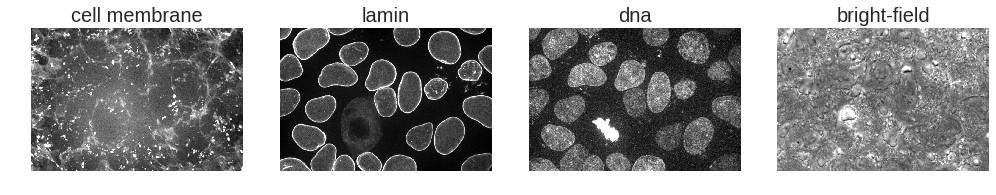

In [4]:
# Make plotting max projections easier
def max_project(ax, img):
  max_img = img.max(0)
  max_scale = np.percentile(max_img, 99)
  ax.imshow(max_img, vmax=max_scale)
  ax.axis('off')

# Load the downloaded image into an array
img_fn = cell_line_samples.AICS_13_1165_ome()
img = tifffile.imread(img_fn)

# Show each of the channels we're interested in
channels = {'cell membrane':0, 'lamin':1, 'dna':2, 'bright-field':3}

fig, axes = plt.subplots(1, 4, figsize=(14, 6))
for channel, ax in zip(channels.items(), axes.flat):
  channel_name, channel_index = channel
  ax.set_title(channel_name, fontsize=20)
  max_project(ax, img[:,channel_index])
plt.tight_layout()

What information does each of these channels contain?

* The cell membrane channel captures information from a fluorescent dye (CellMask) used to image this structure
* The lamin channel includes the information from imaging an endogenous fluorescent tag localized to the nuclear envelope (Lamin B1)
* The DNA channel shows the information from a fluorescent dye (Hoechst) used to image this structure
* Bright-field is a non-fluorescence image of the scene (note the inherent constrast but much lower specificity for the structures represented in the three previous channels)

We've claimed that our model has learned how to predict the fluorescence channels from the bright-field image. Can we show that in action? Let's download and read in our model weights:



In [0]:
import torch
import fnet # our implementation of u-net for fluorescent prediction
import fnet.transforms

# Download trained model weights, find the file that predicts the DNA channel
quilt.install('aics/label_free')
from quilt.data.aics import label_free
dna_model_fn = label_free.dna.model()

# Load the weights into our model
dna_model = fnet.fnet_model.Model()
dna_model.load_state(dna_model_fn, gpu_ids=0)

### Predicting Fluorescent Images from Brightfield Images

Now that our model is loaded, let's prepare the previously loaded image for use with our model.

In this first example, we are going to predict the DNA fluorescent dye image.

In [0]:
# Prep the image for input into the model
full_brightfield = img[:, channels['bright-field'],:,:]
dna_opts = json.load(open(label_free.dna.train_options()))
small_brightfield = fnet.transforms.prep_ndarray(full_brightfield, dna_opts['transform_signal'])
model_input = fnet.transforms.ndarray_to_tensor(small_brightfield)

Great! Our image is prepped; time to predict the DNA fluorescent dye image.

In [0]:
# Predict the dna structure and convert back to ndarray
model_output = dna_model.predict(model_input)
predicted_dna = fnet.transforms.tensor_to_ndarray(model_output)

The output image has a lower resolution (makes the model easier to fit into memory).

To compare the observed DNA fluorescent dye image with our predicted DNA fluorescent dye image, we prepare the observed image for output as well.

In [0]:
# To compare the two images, prep the original
full_dna = img[:, channels['dna'],:,:]
small_dna = fnet.transforms.prep_ndarray(full_dna, dna_opts['transform_signal'])

Let's also prepare the images for display by normalizing and clipping outliers.

In [0]:
# Find the observed and predicted outlier cutoff points
target_flat = small_dna.copy().flatten()
min_px = np.percentile(target_flat, 0.02)
max_px = np.percentile(target_flat, 99.8)

# normalize and clip
def prep_image_for_display(img, min_px, max_px, clip_lower=0, clip_upper=1):
  img = img.copy() - min_px
  img /= (max_px - min_px)
  img[img < clip_lower] = clip_lower
  img[img > clip_upper] = clip_upper
  return img

display_obs = prep_image_for_display(small_dna, min_px, max_px)
display_pred = prep_image_for_display(predicted_dna, min_px, max_px)

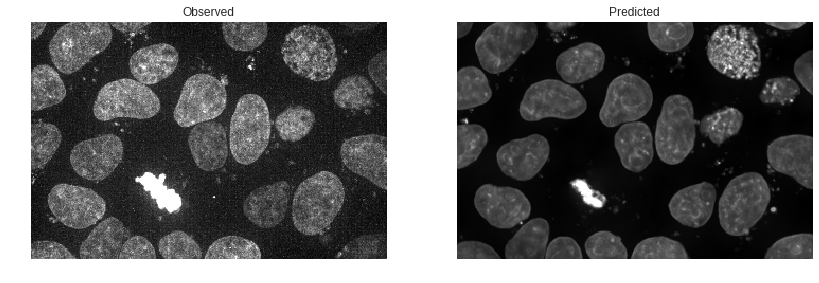

In [10]:
imgs = {'Observed': display_obs,
       'Predicted': display_pred}

# Display the observed and the predicted
fig, axes = plt.subplots(1, len(imgs), figsize=(14,6))
for label, ax in zip(imgs.keys(), axes.flat):
  ax.imshow(imgs[label].max(0))
  ax.set_title(label)
  ax.axis('off')

### Visualizing the Difference

We'd like a better sense of how our prediction differs from the observed image than we can get from the above two images at a glance. Let's compare them in a couple of other ways. The simplest comparison is simply to toggle back and forth between the two images. This lets your eye pick out differences that aren't apparent when you have to move from one image to the next. 

This may be helpful in finding areas where our prediction is noticeably off.

In [0]:
# Create a gif of observed to predicted
from IPython.display import Image
import imageio

ordered_imgs = [display_obs.max(0), display_pred.max(0)]
imageio.mimsave('compare.gif', ordered_imgs, duration=2)

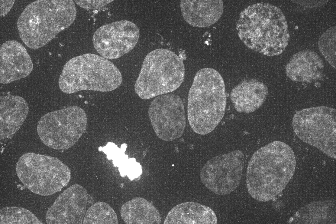

In [12]:
with open('compare.gif', 'rb') as f:
  display(Image(data=f.read(), format='png'))

To my eye this shows that our predictions are largely accurate in location, with some underprediction of the extent of the DNA dye uptake by the mitotic cell. Also of interest is that our predicted image is a bit smoother or less grainy than the observed image. We can put this down to stochastic uptake of dye or dye clumping that the model is unable to predict.

But how else can we visualize the location differences? Let's take a look: 

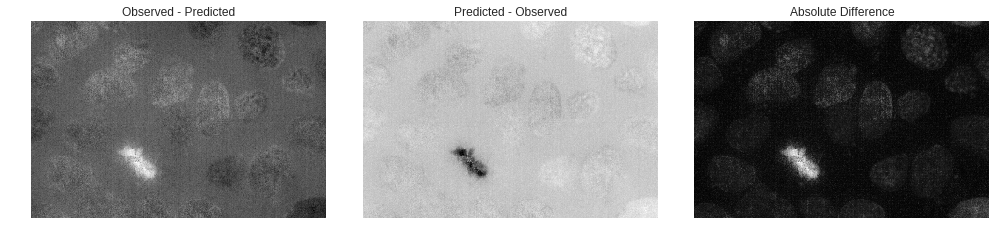

In [13]:
imgs = {'Observed - Predicted': small_dna - predicted_dna,
       'Predicted - Observed': predicted_dna - small_dna,
       'Absolute Difference': abs(small_dna - predicted_dna)}

# Find the difference images outlier cut off points
unified_flat = np.append(np.empty(0,), [imgs[l] for l in imgs]).flatten()
min_px = np.percentile(unified_flat, 0.02)
max_px = np.percentile(unified_flat, 99.8)

fig, axes = plt.subplots(1, len(imgs), figsize=(14,10))
for label, ax in zip(imgs.keys(), axes.flat):
  display_img = prep_image_for_display(imgs[label], min_px, max_px)
  ax.imshow(display_img.mean(0))
  ax.set_title(label)
  ax.axis('off')

plt.tight_layout()

**Observed - Predicted** provides us information on where we underpredict, and you can instantly see that we underpredict the mitotic the most out of all other cells present in the image.

**Predicted - Observed** gives context as to where we overpredict. Noticable here is that it looks as though we generally add noise to the image, even though in the displayed predicted image it looked as though we didn't. This is due to how the model was trained. Because the model cannot predict the random noise generated by fluorescence microscopy, it instead averages the spots where it thinks noise would be present.

**Absolute Difference** shows us all the spots in a unified image of where our prediction was incorrect when compared to the observed. With largest difference being at the mitotic of course and all other points looking like they are mainly differences in greyscale intensity between the prediction and observed and not too many cell location differences.

## Uses of Our Predictions

In the small examples above we showed the relative location accuracy of our predictions and if you would like to learn more about the overall accuracy of our predictions we encourage you to read our paper. But what value can we gain from these predictions. We will first look at segmentation followed by predicting structures not tagged. 

### Segmentation and Thresholding

Segmentation is a large part of our pipeline so let's see how the observed fluorescence image compare to the predicted under a threshold.

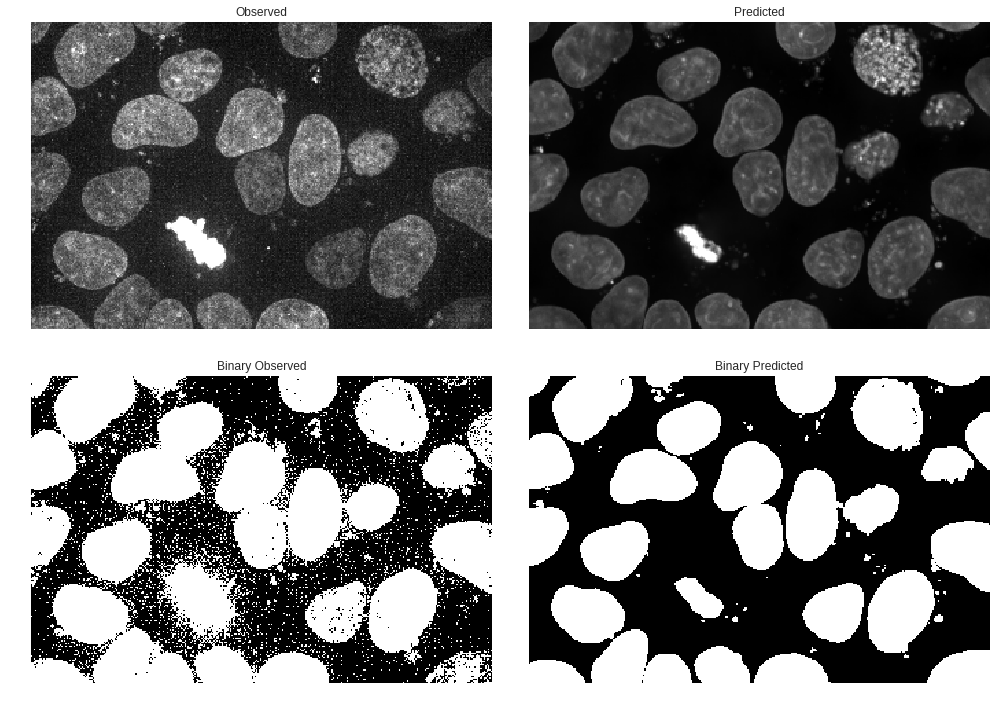

In [14]:
from skimage.filters import threshold_otsu

thresh_obs = threshold_otsu(small_dna)
binary_obs = small_dna > thresh_obs
thresh_pred = threshold_otsu(predicted_dna)
binary_pred = predicted_dna > thresh_pred

imgs = {'Observed': display_obs,
      'Predicted': display_pred,
      'Binary Observed': binary_obs,
      'Binary Predicted': binary_pred}

fig, axes = plt.subplots(2, int(len(imgs) / 2), figsize=(14,10))
for label, ax in zip(imgs.keys(), axes.flat):
  ax.imshow(imgs[label].max(0))
  ax.set_title(label)
  ax.axis('off')

plt.tight_layout()

It was pretty intuitive that our predictions were generally 'smoother' and had less noise in the observed fluorescence but the thresholding shows how much noise was present in the original that is filtered out on the thresholded prediction.

While we can continue on using the predicted image as a segmentation input itself we could also use the binary predicted image as a mask for the original to view a cleaned up, or de-noised original image. In short, let's use the binary predicted as a clipping mask for the original observed fluorescence image.

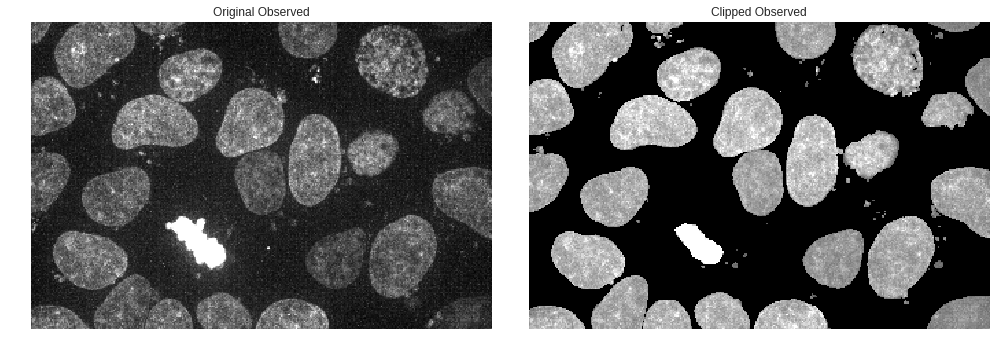

In [15]:
# Use binary predicted as a clipping mask
clipped_obs = small_dna.copy()
clipped_flat = small_dna.flatten()
clipped_obs[binary_pred==False] = min(clipped_flat)
clipped_flat = clipped_obs.flatten()
min_px = np.percentile(clipped_flat, 0.02)
max_px = np.percentile(clipped_flat, 99.8)
clipped_obs = prep_image_for_display(clipped_obs, min_px, max_px)

imgs = {'Original Observed': display_obs,
       'Clipped Observed': clipped_obs}

fig, axes = plt.subplots(1, len(imgs), figsize=(14,10))
for label, ax in zip(imgs.keys(), axes.flat):
  ax.imshow(imgs[label].max(0))
  ax.set_title(label)
  ax.axis('off')

plt.tight_layout()

That looks much better! Being able to filter out some of the noise while still using the original observed fluorescence will be valuable in generating better segmentations and performing feature analysis.

### Predicting Structures not Tagged

These error plots give us some confidence in our ability to predict where DNA fluorescence will appear. We can plot simmilarly estimate error for our other tag models, but this is left as an exercise for the reader. Hard values for how well each of these models work are found in [the accompanying paper](https://www.biorxiv.org/content/early/2018/03/28/289504). 

Instead let's end with an estimate of where the nuclear envelope is for several images.

In [0]:
# Get the model file
lamin_model_fn = label_free.lamin_b1.model()
lamin_opts = json.load(open(label_free.lamin_b1.train_options()))

# Load the weights into our model
lamin_model = fnet.fnet_model.Model()
lamin_model.load_state(lamin_model_fn, gpu_ids=0)

# Function to predict an output image using the model provided
def predict_img(img, model, transforms):
  # Prep the image for input into the model
  full_brightfield = img[:, 3,:,:]
  img_in = fnet.transforms.prep_ndarray(full_brightfield, transforms)
  model_input = fnet.transforms.ndarray_to_tensor(img_in)
  
  # Predict the lamin structure and convert back to ndarray
  model_output = model.predict(model_input)
  predicted_out = fnet.transforms.tensor_to_ndarray(model_output)
  
  return predicted_out

In [0]:
# Generate predictions for each input brightfield image
predictions = dict()

for img_name in cell_line_samples._data_keys():
  if 'ome' in img_name:
    img_fn = getattr(cell_line_samples, img_name)()
    img = tifffile.imread(img_fn)
    prediction = predict_img(img, lamin_model, lamin_opts['transform_signal'])
    predictions[img_name] = prediction

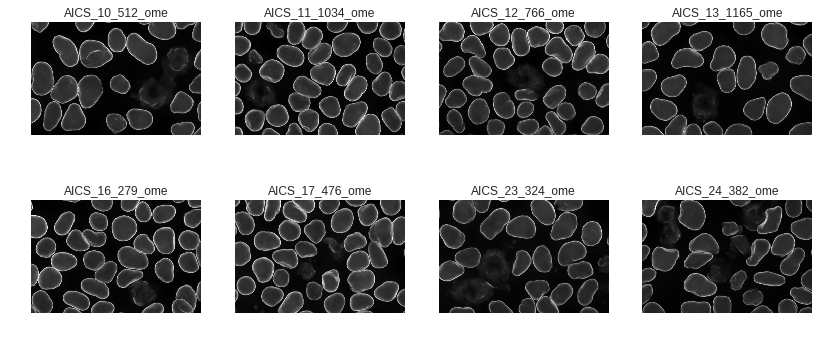

In [18]:
# Display each nuclear envelope prediction
fig, axes = plt.subplots(2, int(len(predictions) / 2), figsize=(14,6))
for img_name, ax in zip(predictions.keys(), axes.flat):
  ax.imshow(predictions[img_name].max(0))
  ax.set_title(img_name)
  ax.axis('off')

What a nice way to get information from a brightfield image using patterns of structures we've seen in other images! We can see fluorescent structures in cells where we haven't even labeled them. In cases where we can do a little initial dying or labeling to train models of this type, this can drastically improve the interpretability of large sets of brightfield images.
